# 3D Printer DataSet for Mechanical Engineers

Import Data

In [1]:
import numpy as np
import pandas as pd
import pandashelpers
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import seaborn as sns

/home/thom/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = pd.read_csv("data.csv").clean_column_names()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
layer_height          50 non-null float64
wall_thickness        50 non-null int64
infill_density        50 non-null int64
infill_pattern        50 non-null object
nozzle_temperature    50 non-null int64
bed_temperature       50 non-null int64
print_speed           50 non-null int64
material              50 non-null object
fan_speed             50 non-null int64
roughness             50 non-null int64
tension_strength      50 non-null int64
elongation            50 non-null float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [4]:
for column in data.columns:
    print(column)
    print(sorted(data[column].unique()))

layer_height
[0.02, 0.06, 0.1, 0.15, 0.2]
wall_thickness
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
infill_density
[10, 20, 30, 40, 50, 60, 70, 80, 90]
infill_pattern
['grid', 'honeycomb']
nozzle_temperature
[200, 205, 210, 215, 220, 225, 230, 240, 250]
bed_temperature
[60, 65, 70, 75, 80]
print_speed
[40, 60, 120]
material
['abs', 'pla']
fan_speed
[0, 25, 50, 75, 100]
roughness
[21, 24, 25, 30, 32, 40, 55, 60, 68, 74, 75, 88, 92, 118, 120, 121, 126, 128, 138, 144, 145, 154, 163, 168, 172, 176, 180, 192, 200, 212, 220, 225, 244, 265, 276, 278, 289, 298, 312, 321, 326, 357, 360, 368]
tension_strength
[4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 37]
elongation
[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.7, 2.8, 2.9, 3.1, 3.2, 3.3]


In [5]:
y = data[data.columns.intersection(['tension_strength'])]
#x = data[data.columns.difference(['tension_strength','elongation','roughness'])]
x = data[['layer_height','infill_density','nozzle_temperature','wall_thickness']]
x_numeric=x.select_dtypes(include=np.number)
x_nonnumeric=x.select_dtypes(exclude=np.number)

In [6]:
#x = pd.get_dummies(x_nonnumeric).join(x_numeric)

In [7]:
regressor_rf = RandomForestRegressor()
regressor_rf.fit(x,y.values.reshape(-1))

regressor_linear = LinearRegression()
regressor_linear.fit(x,y.values.reshape(-1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
feature_importance = pd.concat([pd.Series(regressor_rf.feature_importances_,name='importance'),
                                pd.Series(x.columns,name='feature')
                               ],axis=1
                              ).sort_values('importance')

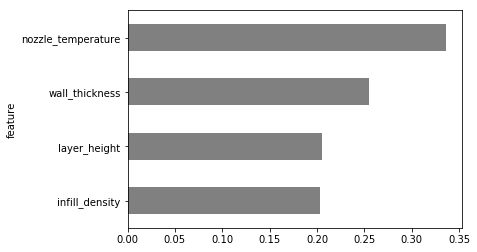

In [9]:
feature_importance.plot.barh(x='feature',
                             y='importance',
                             color='grey',
                             legend=False
                            )


In [10]:
feature_importance['feature']

1        infill_density
0          layer_height
3        wall_thickness
2    nozzle_temperature
Name: feature, dtype: object

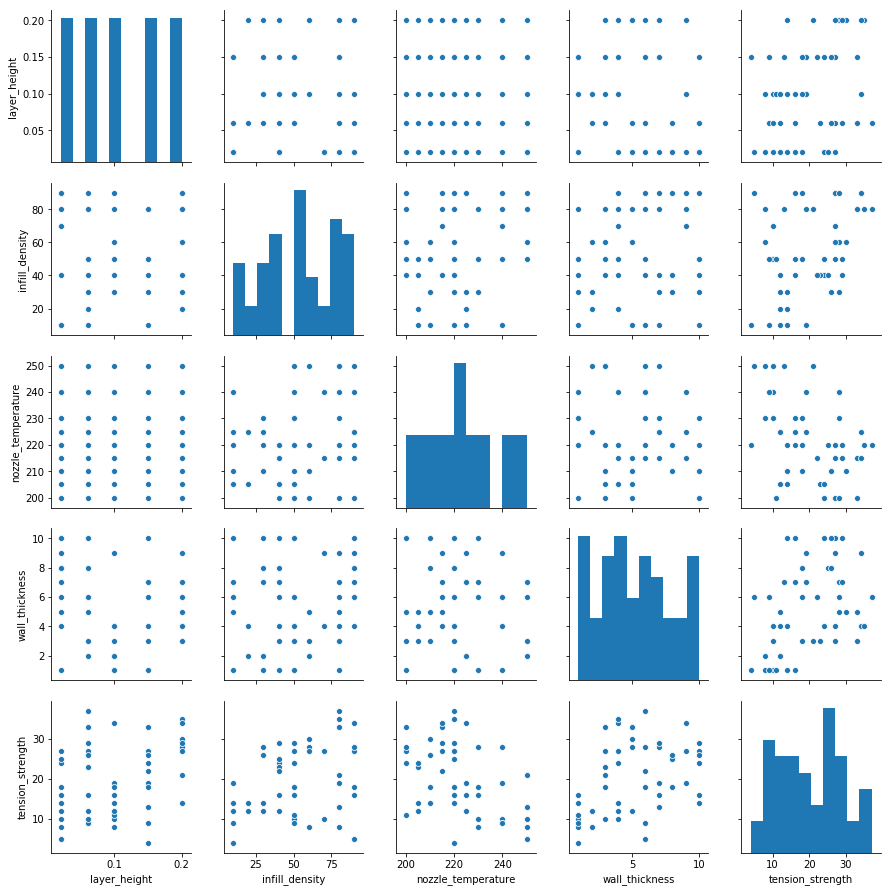

In [11]:
sns.pairplot(x.join(y))

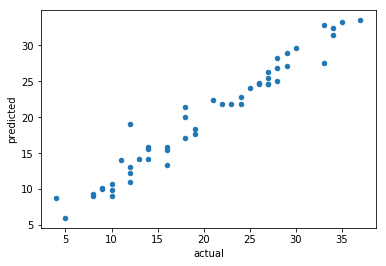

In [12]:
pd.concat([pd.Series(regressor_rf.predict(x),name='predicted'),
           pd.Series(y.values.reshape(-1),name='actual')
          ],axis=1
         ).plot.scatter(x='actual',y='predicted')

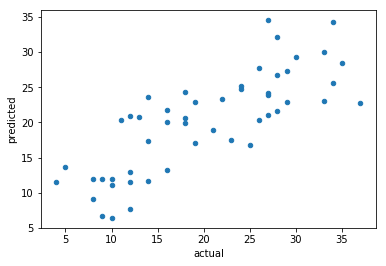

In [13]:
pd.concat([pd.Series(regressor_linear.predict(x),name='predicted'),
           pd.Series(y.values.reshape(-1),name='actual')
          ],axis=1
         ).plot.scatter(x='actual',y='predicted')

In [14]:
metadata = pd.read_csv('metadata.csv')

In [15]:
metadata.columns

Index(['Unnamed: 0', '--fill-angle', '--fill-density', '--fill-pattern',
       '--infill-every-layers', '--layer-height', '--perimeters',
       '--solid-infill-speed', '--solid-layers', '--temperature',
       ...
       'top_solid_infill_speed ', 'top_solid_layers ', 'travel_speed ',
       'use_firmware_retraction ', 'use_relative_e_distances ',
       'use_volumetric_e ', 'vibration_limit ', 'wipe ',
       'xy_size_compensation ', 'z_offset '],
      dtype='object', length=145)

In [16]:
newx = metadata[['--layer-height',
                 '--fill-density',
                 '--temperature',
                 '--solid-layers']
               ]

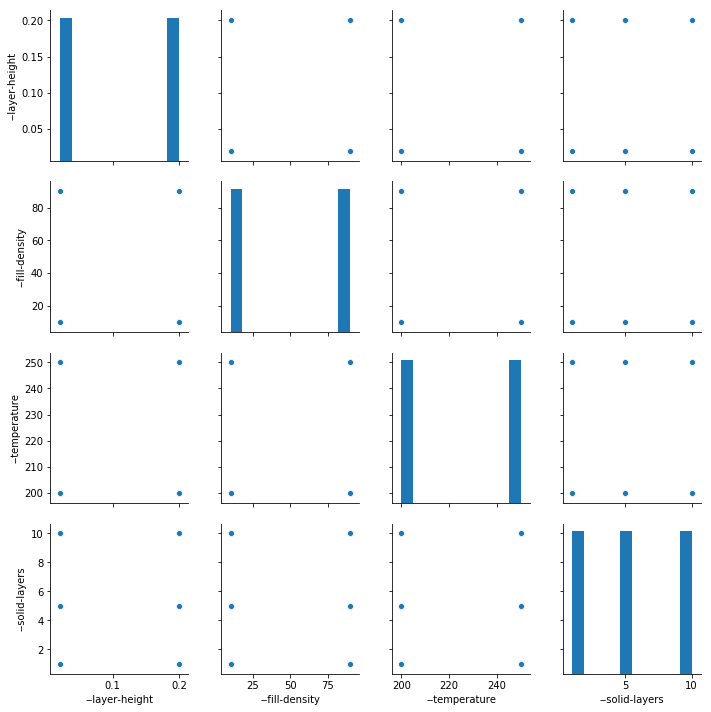

In [17]:
sns.pairplot(newx)

In [18]:
tensile = regressor_linear.predict(newx)

In [19]:
metadata = metadata.join(pd.Series(tensile,name='tensile_strength_predicted'))

In [20]:
filament = metadata['filament used '].str.strip(' ')\
                                    .str.split(' ',expand=True)\
                                    .rename(columns={0:'filament_used_mm',
                                                     1:'filament_used_cm3'
                                                    }
                                           )


Let's multiply these columns by 100 to make them more understandable.

In [21]:
metadata['filament_used_mm'] = filament['filament_used_mm'].str.replace('mm','')\
                                                           .apply(float)

metadata['filament_used_cm3'] = filament['filament_used_cm3'].str.strip('()')\
                                                             .str.replace('cm3','')\
                                                             .apply(float)

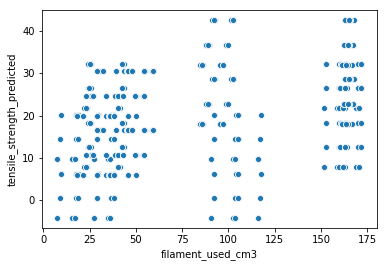

In [22]:
sns.scatterplot(x='filament_used_cm3',y='tensile_strength_predicted',data=metadata)

In [32]:
y = metadata[metadata.columns.intersection(['filament_used_cm3'])]
x = metadata[metadata.columns.difference(['filament_used_cm3'])]
x_numeric = x.select_dtypes(include=np.number)
x_non_numeric = x.select_dtypes(exclude=np.number)

In [33]:
regressor_rf = RandomForestRegressor()

In [34]:
regressor_rf.fit(x_numeric.dropna(1),y)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [35]:
feature_importance = pd.concat([pd.Series(regressor_rf.feature_importances_,name='importance'),
                                pd.Series(x.columns,name='feature')
                               ],axis=1
                              ).sort_values('importance')

In [45]:
feature_importance.dropna()

,importance,feature
58,0.000000e+00,gcode_flavor
82,0.000000e+00,overhangs
81,0.000000e+00,output_filename_format
80,0.000000e+00,ooze_prevention
79,0.000000e+00,only_retract_when_crossing_perimeters
78,0.000000e+00,nozzle_diameter
77,0.000000e+00,notes
76,0.000000e+00,min_skirt_length
75,0.000000e+00,min_print_speed
74,0.000000e+00,min_fan_speed


In [40]:
feature_importance.plot.barh(x='feature',
                             y='importance',
                             color='grey',
                             legend=False
                            )


TypeError: unhashable type: 'slice'

In [ ]:
data.layer_height = data.layer_height*100
data.elongation = data.elongation*100

In [ ]:
data.head()

In this data set, ABS and PLA assigned 0 and 1 values for materials.

In [ ]:
data.material = [0 if each == "abs" else 1 for each in data.material]
# abs = 0, pla = 1

data.infill_pattern = [0 if each == "grid" else 1 for each in data.infill_pattern]
# grid = 0, honeycomb = 1

In [ ]:
data.head()

Seperate Input parameters and Prediction Materials.

In [ ]:
y_data = data.material.values
x_data = data.drop(["material"],axis=1)

In [ ]:
absm = data[data.material == 0]
pla = data[data.material == 1]

In [ ]:
absm.head()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(absm.fan_speed,absm.tension_strenght,color="red",label="ABS",alpha= 0.5)
plt.scatter(pla.fan_speed,pla.tension_strenght,color="green",label="PLA",alpha= 0.5)
plt.xlabel("Fan Speed")
plt.ylabel("Tension Strength")
plt.legend()
plt.show()

As you see, the air circulation not good for ABS

In [ ]:
plt.scatter(absm.layer_height,absm.roughness,color="blue",label="ABS",alpha= 0.9)
plt.scatter(pla.layer_height,pla.roughness,color="pink",label="PLA",alpha= 0.9)
plt.xlabel("Layer Height")
plt.ylabel("Roughness")
plt.legend()
plt.show()

You can see as the layer height increases, the tensile strength increases. But PLA smoother than ABS

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = data.infill_density
y = data.wall_thickness
z = data.tension_strenght

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Infill Density')
ax.set_ylabel('Wall Thickness')
ax.set_zlabel('Tension Strenght')

plt.show()

In [ ]:
# normalization 
x_norm = (x_data - np.min(x_data))/(np.max(x_data)-np.min(x_data))

# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_norm,y_data,test_size = 0.3,random_state=1)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3) # n_neighbors = k
knn.fit(x_train,y_train)
prediction = knn.predict(x_test)
print(" {} nn score: {} ".format(3,knn.score(x_test,y_test)))

score_list = []
for each in range(1,15):
    knn2 = KNeighborsClassifier(n_neighbors = each)
    knn2.fit(x_train,y_train)
    score_list.append(knn2.score(x_test,y_test))
    print(" {} nn score: {} ".format(each,knn2.score(x_test,y_test)))
    
plt.plot(range(1,15),score_list)
plt.xlabel("k values")
plt.ylabel("accuracy")
plt.show()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Input, Dense, Flatten
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Dense(32,input_dim=11))
model.add(BatchNormalization(axis = -1))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(16))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_data,y, epochs=500, batch_size =32, validation_split= 0.20)

In [ ]:
a1 = 4 #layer_height*100
a2 = 5 #wall_thickness
a3 = 60 #infill_density
a4 = 0 #infilkk_pattern
a5 = 232 #nozzle_temperature 
a6 = 74 #bed_temperature
a7 = 90 #print_speed
a8 = 100 #fan_speed
a9 = 150 #roughness
a10 = 30 #tension_strenght
a11 = 200 #elangation*100

tahmin = np.array([a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11]).reshape(1,11)
print(model.predict_classes(tahmin))

if model.predict_classes(tahmin) == 0: 
    print("Material is ABS")
else:   
    print("Material is PLA.")